In [ ]:
import os
import math
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
#data_path = 'C:/Users/adommalapati002/OneDrive - Guidehouse/Documents/NSS Data/2020/fy2020_table13.xlsx'

In [ ]:
refugee_data = pd.read_excel('fy2020_table13.xlsx', skiprows=3, skipfooter=2)
print(refugee_data.columns, len(refugee_data))
refugee_data

Index(['Year', 'Number'], dtype='object') 41


,Year,Number
0,1980,207116
1,1981,159252
2,1982,98096
3,1983,61218
4,1984,70393
5,1985,67704
6,1986,62146
7,1987,64528
8,1988,76483
9,1989,107070


In [ ]:
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
 
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
#    if result is not None:
#        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = range(2)
    d_params = range(2)
    q_params = range(5)
    t_params = ['n','c','t','ct']
    P_params = range(5)
    D_params = range(2)
    Q_params = range(2)
    m_params = range(2)
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p, d, q), (P, D, Q, m), t]
                                    models.append(cfg)
    return models

In [ ]:
# define dataset
#data = refugee_data['Number'].values
print(refugee_data.shape)
# data split
n_test = 10
# model configs
cfg_list = sarima_configs()
print('Configurations: ', len(cfg_list))
# grid search
scores = grid_search(refugee_data['Number'].values, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

(41, 2)
Configurations:  3200
done
[(1, 0, 1), (0, 0, 0, 0), 'ct'] 16057.440530305996
[(1, 0, 0), (0, 0, 0, 0), 'n'] 16098.395079529719
[(1, 1, 1), (0, 0, 0, 0), 'ct'] 16188.923802399948


In [ ]:
refugee_data["Number"].values

array([207116, 159252,  98096,  61218,  70393,  67704,  62146,  64528,
        76483, 107070, 122066, 113389, 115548, 114181, 111680,  98973,
        75421,  69653,  76712,  85285,  72165,  68920,  26785,  28286,
        52840,  53738,  41094,  48218,  60107,  74602,  73293,  56384,
        58179,  69909,  69975,  69920,  84989,  53691,  22405,  29916,
        11840])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   41
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -459.373
Date:                Thu, 03 Nov 2022   AIC                            926.746
Time:                        16:09:39   BIC                            933.600
Sample:                             0   HQIC                           929.242
                                 - 41                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.525e+04   3.64e+04      2.069      0.039    3964.331    1.47e+05
ar.L1          0.8872      0.081     10.994      0.000       0.729       1.045
ma.L1          0.6027      0.144      4.173      0.0

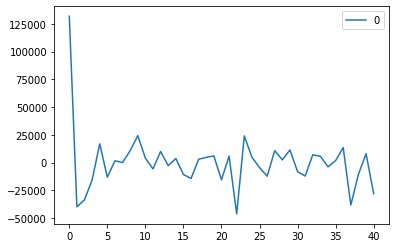

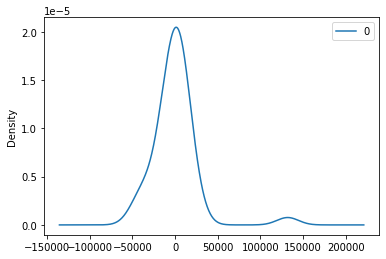

                   0
count      41.000000
mean     -130.959483
std     26666.528728
min    -46335.661146
25%    -12174.367896
50%      1701.244480
75%      7004.604334
max    131864.471475


In [ ]:
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
# load dataset
series = refugee_data["Number"].values
#series.index = series.index.to_period('Y')
# fit model
model = ARIMA(series, order=(1,0,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

predicted=81758.592328, expected=73293.000000
predicted=69678.612684, expected=56384.000000
predicted=51882.119317, expected=58179.000000
predicted=64795.924822, expected=69909.000000
predicted=74320.629566, expected=69975.000000
predicted=68734.631545, expected=69920.000000
predicted=71907.893420, expected=84989.000000
predicted=92144.282044, expected=53691.000000
predicted=35429.236047, expected=22405.000000
predicted=22107.643739, expected=29916.000000
predicted=40219.779791, expected=11840.000000
Test RMSE: 16570.023


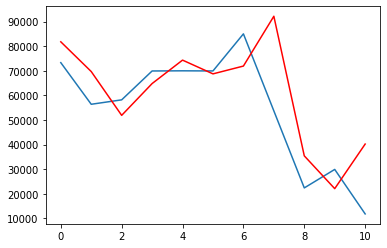

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#series.index = series.index.to_period('M')
# split into train and test sets
X = series
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,1))
	model_fit = model.fit()
	output = model_fit.forecast()
  #futures = model_fit.predict()
	yhat = output[0]
	predictions.append(int(yhat))
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
#series.index = series.index.to_period('M')
# split into train and test sets
X = series
#size = int(len(X) * 0.75)
#train, test = X[0:size], X[size:len(X)]
history = [x for x in X]
predictions = list()
# walk-forward validation
model = ARIMA(history, order=(1,0,1))
model_fit = model.fit()
print(len(X))
output = model_fit.predict(start=41, end=50, dynamic = True)
output = [int(x) for x in output]
print(output)

30
[27839, 27264, 26775, 26359, 26005, 25704, 25447, 25229, 25043, 24886]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2292: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


In [ ]:
future_years = ['2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030']
Future = pd.DataFrame({'Year':future_years, 'Model Forecast': output})

In [ ]:
Future = pd.DataFrame({'Year':future_years, 'Model Forecast': output})

In [ ]:
Future

,Year,Model Forecast
0,2021,2124
1,2022,10371
2,2023,17688
3,2024,24180
4,2025,29940
5,2026,35050
6,2027,39584
7,2028,43607
8,2029,47176
9,2030,50342


In [ ]:
len(predictions)

0

In [ ]:
refugee_data['Year'][-10:]

31    2011
32    2012
33    2013
34    2014
35    2015
36    2016
37    2017
38    2018
39    2019
40    2020
Name: Year, dtype: int64

In [ ]:
len(predictions)

0

In [ ]:
import pandas as pd
Model_Fit = pd.DataFrame({'Year':refugee_data['Year'][-11:].values, 'Actual': test, 'Predicted': predictions})

In [ ]:
Model_Fit

,Year,Actual,Predicted
0,2010,73293,81758
1,2011,56384,69678
2,2012,58179,51882
3,2013,69909,64795
4,2014,69975,74320
5,2015,69920,68734
6,2016,84989,71907
7,2017,53691,92144
8,2018,22405,35429
9,2019,29916,22107


In [ ]:
combined = pd.concat([Model_Fit, Future], ignore_index = True)
combined

,Year,Actual,Predicted,Model Forecast
0,2010,73293.0,81758.0,NaN
1,2011,56384.0,69678.0,NaN
2,2012,58179.0,51882.0,NaN
3,2013,69909.0,64795.0,NaN
4,2014,69975.0,74320.0,NaN
5,2015,69920.0,68734.0,NaN
6,2016,84989.0,71907.0,NaN
7,2017,53691.0,92144.0,NaN
8,2018,22405.0,35429.0,NaN
9,2019,29916.0,22107.0,NaN


In [ ]:
train_data = refugee_data[:-11]
train_data.rename(columns = {'Number':'Actual'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train_data

,Year,Actual
0,1980,207116
1,1981,159252
2,1982,98096
3,1983,61218
4,1984,70393
5,1985,67704
6,1986,62146
7,1987,64528
8,1988,76483
9,1989,107070


In [ ]:
all_data = pd.concat([train_data, combined], ignore_index = True)
all_data

,Year,Actual,Predicted,Model Forecast
0,1980,207116.0,NaN,NaN
1,1981,159252.0,NaN,NaN
2,1982,98096.0,NaN,NaN
3,1983,61218.0,NaN,NaN
4,1984,70393.0,NaN,NaN
5,1985,67704.0,NaN,NaN
6,1986,62146.0,NaN,NaN
7,1987,64528.0,NaN,NaN
8,1988,76483.0,NaN,NaN
9,1989,107070.0,NaN,NaN


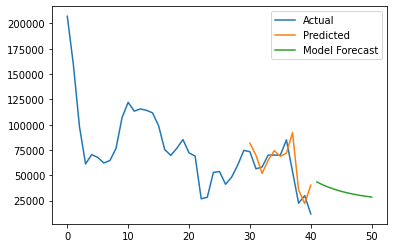

In [ ]:
all_data.plot()

In [ ]:
asylee_data = pd.read_excel('fy2020_table16.xlsx', skiprows=3, skipfooter=1)
print(asylee_data.columns, len(asylee_data))
asylee_data

Index(['Year', 'Total', 'Affirmative', 'Defensive'], dtype='object') 31


,Year,Total,Affirmative,Defensive
0,1990,8472,5672,2800
1,1991,5035,2908,2127
2,1992,6307,4123,2184
3,1993,9543,7509,2034
4,1994,13828,11775,2053
5,1995,20703,17573,3130
6,1996,23532,18624,4908
7,1997,22939,16380,6559
8,1998,20507,13216,7291
9,1999,26571,18150,8421


In [ ]:
# define dataset
#data = asylee_data['Affirmative'].values
print(asylee_data.shape)
# data split
n_test = 10
# model configs
cfg_list = sarima_configs()
print('Configurations: ', len(cfg_list))
# grid search
scores = grid_search(asylee_data['Defensive'].values, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

(31, 4)
Configurations:  3200
done
[(0, 0, 2), (0, 0, 0, 0), 'ct'] 2554.0164388545936
[(0, 1, 0), (0, 0, 0, 0), 'c'] 2576.1284686043678
[(0, 0, 2), (0, 0, 0, 0), 'c'] 2590.066297440993


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   31
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -281.727
Date:                Thu, 03 Nov 2022   AIC                            571.454
Time:                        15:49:07   BIC                            577.190
Sample:                             0   HQIC                           573.324
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8987.3119    972.312      9.243      0.000    7081.615    1.09e+04
ma.L1          1.0165      0.177      5.751      0.000       0.670       1.363
ma.L2          0.7299      0.166      4.407      0.0

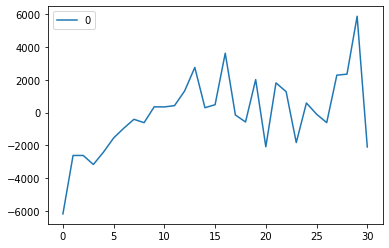

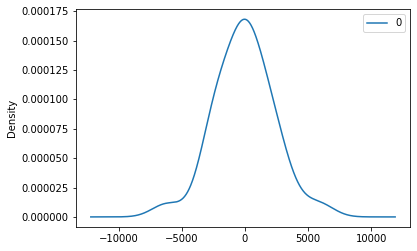

                 0
count    31.000000
mean    -74.084640
std    2324.392101
min   -6187.311939
25%   -1693.421533
50%    -101.385887
75%    1297.066591
max    5874.374073


In [ ]:
# load dataset
series = asylee_data["Defensive"].values
#series.index = series.index.to_period('Y')
# fit model
model = ARIMA(series, order=(0,0,2))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

predicted=7198.085002, expected=10138.000000
predicted=12586.410035, expected=10575.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=6756.505949, expected=9767.000000
predicted=9987.612598, expected=8636.000000
predicted=7985.053101, expected=8140.000000
predicted=7888.832322, expected=8693.000000
predicted=9233.400901, expected=10565.000000
predicted=10352.213909, expected=13194.000000
predicted=12936.215909, expected=18904.000000
predicted=18755.118486, expected=14565.000000
Test RMSE: 2954.241


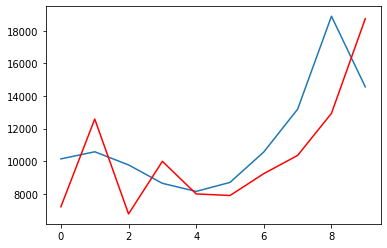

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#series.index = series.index.to_period('M')
# split into train and test sets
X = series
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(0,0,2))
	model_fit = model.fit()
	output = model_fit.forecast()
  #futures = model_fit.predict()
	yhat = output[0]
	predictions.append(int(yhat))
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
len(test)

10

In [ ]:
predictions

[7198, 12586, 6756, 9987, 7985, 7888, 9233, 10352, 12936, 18755]

In [ ]:
test

array([10138, 10575,  9767,  8636,  8140,  8693, 10565, 13194, 18904,
       14565])

In [ ]:
asylee_data["Year"][-10:]

21    2011
22    2012
23    2013
24    2014
25    2015
26    2016
27    2017
28    2018
29    2019
30    2020
Name: Year, dtype: int64

In [ ]:
asylee_total_model_fit = pd.DataFrame({'Year':asylee_data["Year"][-10:].values, 'Defensive Actual':test, 'Defensive Predictions': predictions})
asylee_total_model_fit

,Year,Defensive Actual,Defensive Predictions
0,2011,10138,7198
1,2012,10575,12586
2,2013,9767,6756
3,2014,8636,9987
4,2015,8140,7985
5,2016,8693,7888
6,2017,10565,9233
7,2018,13194,10352
8,2019,18904,12936
9,2020,14565,18755


In [ ]:
series

array([ 2800,  2127,  2184,  2034,  2053,  3130,  4908,  6559,  7291,
        8421,  9236, 10001, 10977, 13376, 13022, 11757, 13304, 12859,
       10892, 10300,  8519, 10138, 10575,  9767,  8636,  8140,  8693,
       10565, 13194, 18904, 14565])

In [ ]:
history = [x for x in X]
# walk-forward validation
model = ARIMA(history, order=(1,0,1))
model_fit = model.fit()
print(len(X))
output = model_fit.predict(start=31, end=40, dynamic = True)
output = [int(x) for x in output]
print(output)

31
[12975, 12493, 12070, 11698, 11371, 11083, 10831, 10609, 10413, 10242]


In [ ]:
future_years = ['2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030']
asylee_total_Future = pd.DataFrame({'Year':future_years, 'Defensive Model Forecast': output})
asylee_total_Future

,Year,Defensive Model Forecast
0,2021,12975
1,2022,12493
2,2023,12070
3,2024,11698
4,2025,11371
5,2026,11083
6,2027,10831
7,2028,10609
8,2029,10413
9,2030,10242


In [ ]:
affirm_test_predicted = pd.concat([asylee_total_model_fit, asylee_total_Future], ignore_index=True)
affirm_test_predicted

,Year,Defensive Actual,Defensive Predictions,Defensive Model Forecast
0,2011,10138.0,7198.0,NaN
1,2012,10575.0,12586.0,NaN
2,2013,9767.0,6756.0,NaN
3,2014,8636.0,9987.0,NaN
4,2015,8140.0,7985.0,NaN
5,2016,8693.0,7888.0,NaN
6,2017,10565.0,9233.0,NaN
7,2018,13194.0,10352.0,NaN
8,2019,18904.0,12936.0,NaN
9,2020,14565.0,18755.0,NaN


In [ ]:
asylee_data = asylee_data.rename(columns = {'Defensive':'Defensive Actual'})

In [ ]:
asylee_data[:-10]

,Year,Total,Affirmative Actual,Defensive Actual
0,1990,8472,5672,2800
1,1991,5035,2908,2127
2,1992,6307,4123,2184
3,1993,9543,7509,2034
4,1994,13828,11775,2053
5,1995,20703,17573,3130
6,1996,23532,18624,4908
7,1997,22939,16380,6559
8,1998,20507,13216,7291
9,1999,26571,18150,8421


In [ ]:
asylee_train_data = asylee_data[:-10][['Year', 'Defensive Actual']]
all_asylee_model = pd.concat([asylee_train_data, affirm_test_predicted], ignore_index = True)
all_asylee_model

,Year,Defensive Actual,Defensive Predictions,Defensive Model Forecast
0,1990,2800.0,NaN,NaN
1,1991,2127.0,NaN,NaN
2,1992,2184.0,NaN,NaN
3,1993,2034.0,NaN,NaN
4,1994,2053.0,NaN,NaN
5,1995,3130.0,NaN,NaN
6,1996,4908.0,NaN,NaN
7,1997,6559.0,NaN,NaN
8,1998,7291.0,NaN,NaN
9,1999,8421.0,NaN,NaN


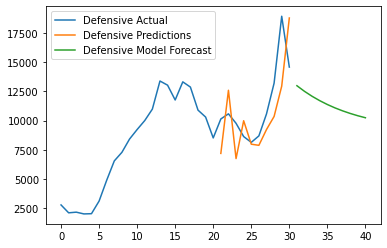

In [ ]:
all_asylee_model.plot()

In [ ]:
all_asylee_model.to_csv('defensive_asylee_model.csv')